# gwexpy.fitting: iminuit-based Fitting Capabilities

This notebook demonstrates how to easily fit `TimeSeries` or `FrequencySeries` data using the `gwexpy.fitting` module.
The backend uses `iminuit`, enabling least-squares fitting with error consideration.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tatsuki-washimi/gwexpy/blob/main/docs/web/en/user_guide/tutorials/advanced_fitting.ipynb)


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.frequencyseries import FrequencySeries
from gwexpy.plot import Plot
from gwexpy.timeseries import TimeSeries

plt.rcParams["figure.figsize"] = (10, 6)

## 1. Data Preparation

Here we create dummy data by adding noise to a Gaussian function.


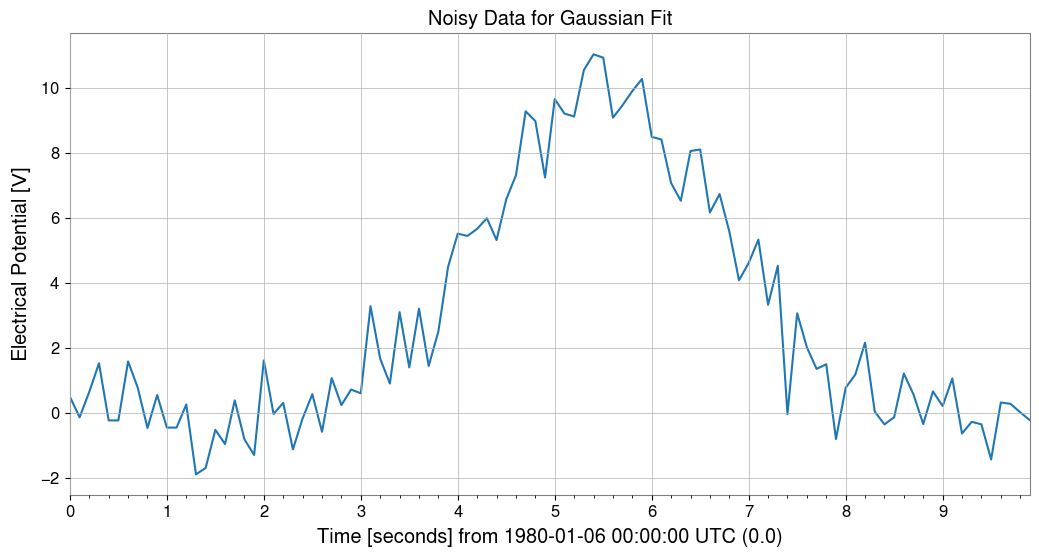

In [2]:
# Define model function (Gaussian)
def gaussian(x, a, mu, sigma):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma**2))


# Generate dummy data
np.random.seed(42)
x = np.linspace(-5, 5, 100)
true_params = {"a": 10, "mu": 0.5, "sigma": 1.2}
y_true = gaussian(x, **true_params)
y_noise = y_true + np.random.normal(0, 1.0, size=len(x))

# Create TimeSeries object
ts = TimeSeries(y_noise, dt=0.1, name="Noisy Gaussian", unit="V")
ts.plot(title="Noisy Data for Gaussian Fit");

## 2. Performing the Fit

Use the `ts.fit()` method to perform fitting.
Specify the model function and initial parameter values `p0` as arguments.


In [3]:
# Fitting
# Specify initial values with p0
result = ts.fit(gaussian, sigma=0.8, p0={"a": 5, "mu": 5, "sigma": 1})

# Display results
display(result)

## 3. Retrieving Results and Plotting

You can retrieve the best-fit parameters, errors, Chi2 values, etc. from the `FitResult` object.
Additionally, the `.plot()` method makes it easy to visualize the results.


Best Fit Parameters: {'a': 10.052918089640286, 'mu': 5.4945648175959265, 'sigma': 1.1593703774715336}
Errors: {'a': 0.21465022616772478, 'mu': 0.028783389431543863, 'sigma': 0.028181477272667253}
Chi2: 125.15392927134539
NDOF: 97


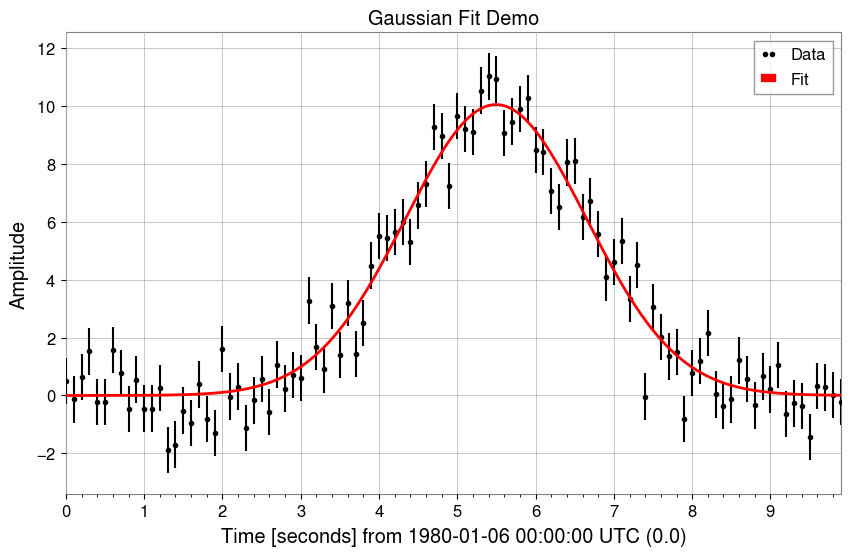

In [4]:
print("Best Fit Parameters:", result.params)
print("Errors:", result.errors)
print("Chi2:", result.chi2)
print("NDOF:", result.ndof)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
result.plot(ax=ax, color="red", linewidth=2)
ax.set_title("Gaussian Fit Demo")
# When using auto-gps, let GWpy handle xlabel (includes epoch)
ax.set_ylabel("Amplitude")
plt.show()

## 4. Specifying Models by String

Instead of defining a model function, you can specify a predefined model name as a string.
Currently supported models: `'gaus'`, `'exp'`, `'pol0'`, `'pol1'`, ... `'pol9'`, `'landau'`, etc.

Below is an example of fitting using `'gaus'`.


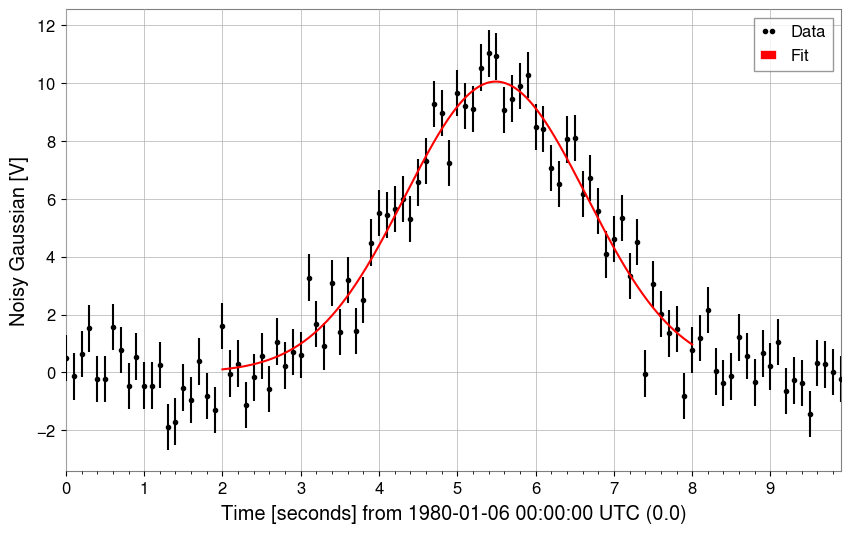

In [5]:
# Fit using string 'gaus'
# Note: Parameter names for predefined models are fixed (for Gaussian: A, mu, sigma)
result_str = ts.fit(
    "gaus", p0={"A": 10, "mu": 5, "sigma": 1.0}, x_range=(2, 8), sigma=0.8
)

# Display results
display(result_str)
result_str.plot();

## 5. Complex Number Fitting (Transfer Functions)

You can also fit complex data such as transfer functions.
The cost function $\chi^2 = \sum (Re_{diff})^2 + \sum (Im_{diff})^2$ is minimized, fitting real and imaginary parts simultaneously.
The result plots automatically become Bode plots (magnitude and phase).


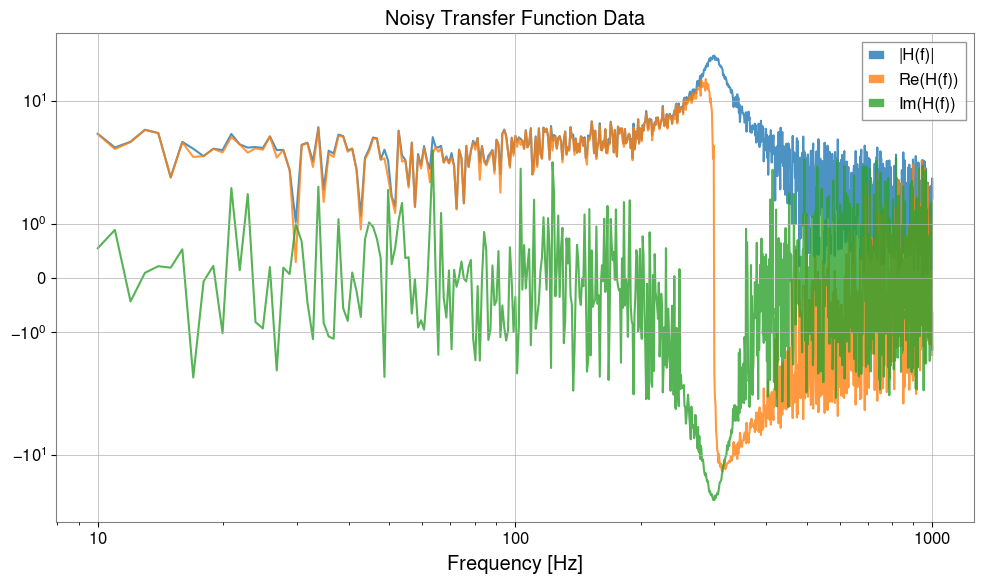

In [6]:
# 1. Define complex model (simple pole)
def pole_model(f, A, f0, Q):
    # H(f) = A / (1 + i * Q * (f/f0 - f0/f))
    # Low-pass filter like but simplified. Let's use standard mechanical transfer function:
    # H(f) = A / [ (f0^2 - f^2) + i * (f0 * f / Q) ]
    omega = 2 * np.pi * f
    omega0 = 2 * np.pi * f0
    return A / ((omega0**2 - omega**2) + 1j * (omega0 * omega / Q))


# 2. Generate data
f = np.linspace(10, 1000, 1000)
p_true = {"A": 1e7, "f0": 300, "Q": 10}
data_clean = pole_model(f, **p_true)

# Add noise (real and imaginary parts independent)
np.random.seed(0)
noise_re = np.random.normal(0, 5, len(f))
noise_im = np.random.normal(0, 5, len(f))
data_noisy = data_clean + 0.2 * noise_re + 0.2j * noise_im

# Create FrequencySeries
fs = FrequencySeries(data_noisy, frequencies=f, name="Transfer Function")
plot = Plot(fs.abs(), fs.real, fs.imag, xscale="log", yscale="symlog", alpha=0.8)
plt.legend(["|H(f)|", "Re(H(f))", "Im(H(f))"])
plt.title("Noisy Transfer Function Data")
plt.tight_layout()
plt.show()

Fit Start...


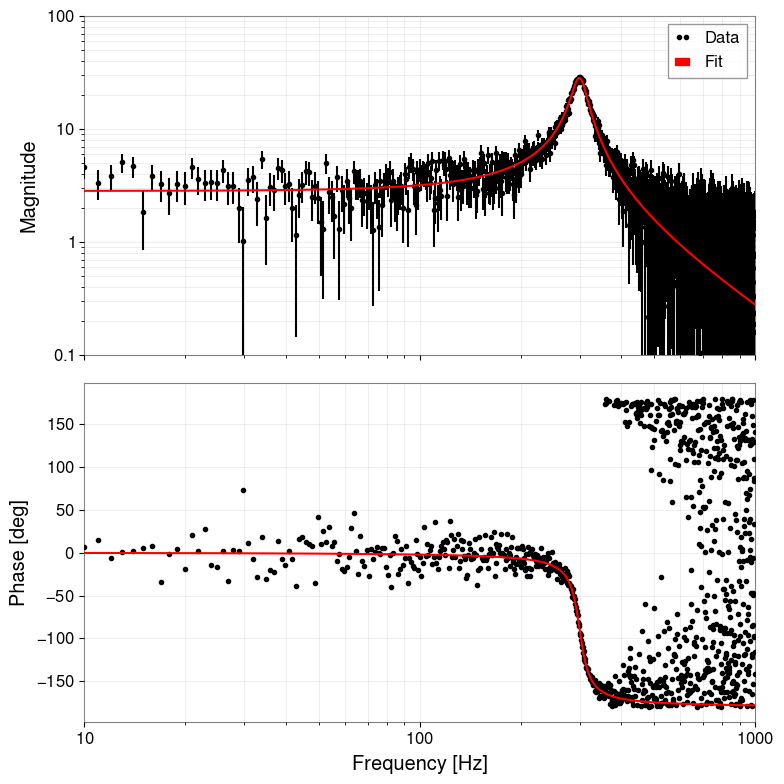

In [7]:
# 3. Fitting
print("Fit Start...")
# Use shifted initial values
result_complex = fs.fit(pole_model, sigma=1.0, p0={"A": 0.8e7, "f0": 320, "Q": 8})

# Display results
display(result_complex)

# 4. Plot (Bode plot)
# Automatically becomes amplitude and phase plots
result_complex.bode_plot()
plt.gcf().get_axes()[0].set_ylim(1e-1, 1e2)
plt.tight_layout()
plt.show()

## 6. MCMC Analysis (emcee)

Using the maximum likelihood estimate obtained from `iminuit` as the initial value, you can perform MCMC (Markov Chain Monte Carlo) analysis using `emcee`.

> **Note:** To use this feature, `emcee` and `corner` must be installed.


In [8]:
# Run MCMC
# n_walkers: number of walkers, n_steps: number of steps, burn_in: number of initial steps to discard
try:
    sampler = result_complex.run_mcmc(n_walkers=32, n_steps=1000, burn_in=200)

    # Create corner plot (visualize posterior distribution)
    # Display true values (or maximum likelihood estimates) with blue lines
    result_complex.plot_corner()

except ImportError as e:
    print(e)
except Exception as e:
    print(f"MCMC Error: {e}")

Please install 'emcee' and 'corner' to use MCMC features.


## Example Usage of New Common Models

These are usage examples of `power_law` and `damped_oscillation` added to `gwexpy.fitting.models`.


Power law alpha: -1.4897338938575226


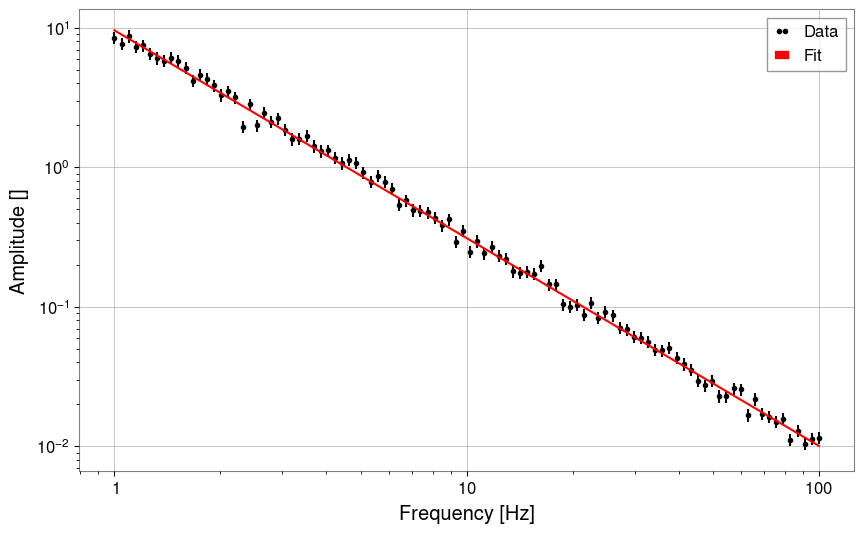

Damped oscillation frequency: 9.989812091376667


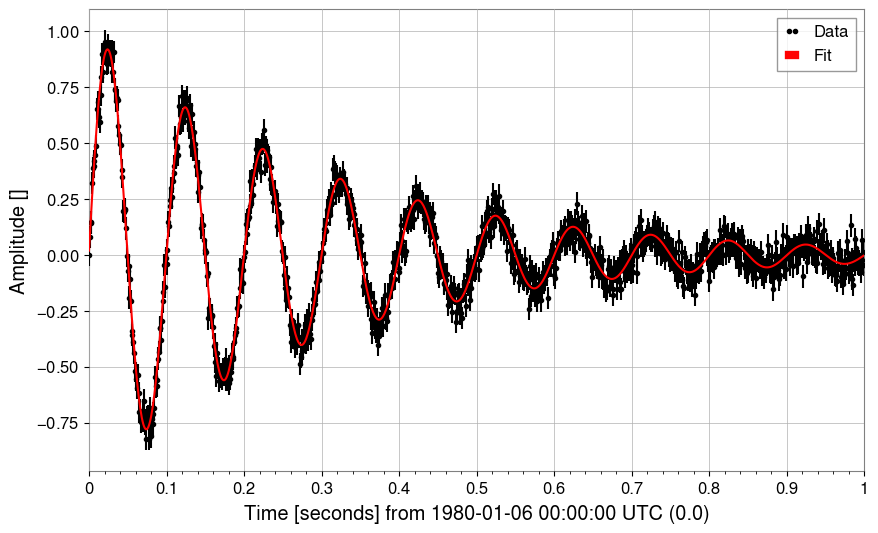

In [9]:
from gwexpy.fitting.models import damped_oscillation, power_law

# Power law
x = np.logspace(0, 2, 100)
y = power_law(x, A=10, alpha=-1.5) * (1 + 0.1 * np.random.normal(size=len(x)))
fs = FrequencySeries(y, frequencies=x)
res_pl = fs.fit("power_law", p0={"A": 5, "alpha": -1}, sigma=y * 0.1)
print("Power law alpha:", res_pl.params["alpha"])
display(res_pl)
res_pl.plot()
plt.xscale("log")
plt.yscale("log")
plt.show()
plt.close()

# Damped oscillation
t = np.linspace(0, 1, 1000)
y_osc = damped_oscillation(t, A=1, tau=0.3, f=10) + 0.05 * np.random.normal(size=len(t))
ts_osc = TimeSeries(y_osc, times=t)
res_osc = ts_osc.fit(
    "damped_oscillation", p0={"A": 0.5, "tau": 0.5, "f": 12}, sigma=0.05
)
print("Damped oscillation frequency:", res_osc.params["f"])
display(res_osc)
res_osc.plot();